In [162]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import math

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
#Loading in the dataset

DATADIR = "D:/Users/Uros/Downloads/fire_dataset"
CATEGORIES = ["fire_images", "non_fire_images"]

for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            RGB_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        except Exception as e:
            pass

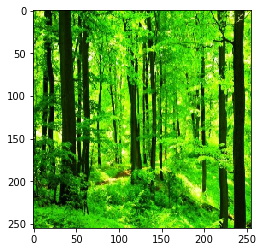

In [3]:
#Setting image size and displaying an example image

IMG_SIZE = 255
resized_image = cv2.resize(RGB_img, (IMG_SIZE, IMG_SIZE))
plt.imshow(resized_image)
plt.show()

In [4]:
#A function to create training data
training_data = []

def create_training_data():
    #Storing the data with corresponding label
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        #Converting image to RGB color map and resizing 
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                RGB_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                resized_image = cv2.resize(RGB_img, (IMG_SIZE, IMG_SIZE))
                training_data.append([resized_image, class_num])
            except Exception as e:
                pass
            
create_training_data()

In [5]:
#Shuffling the data since it's currently sorted as a consequence of the previous function

import random
random.shuffle(training_data)

In [6]:
#Checking to make sure the data is shuffled

for sample in training_data[:20]:
    print (sample[1])

0
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0


IMAGE PREPROCESSING METHODS

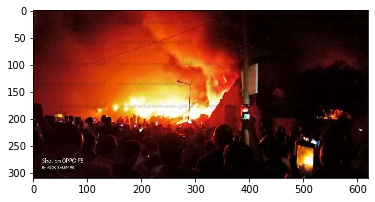

In [7]:
#Loading in an example image for demonstration purposes

eg = cv2.imread('fire5.png')
RGB_eg = cv2.cvtColor(eg, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_eg)
plt.show()

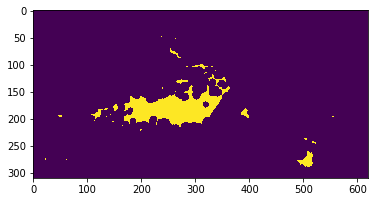

In [8]:
#Creating a mask 

def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_hsv = np.array([0,0,250])
    upper_hsv = np.array([250,255,255])
    
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv) #A mask is a binary image consisting of zero- and non-zero values
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11)) #a matrix that determines the type of the transformation
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel) #final version of a mask
    
    return mask

masked_img = create_mask_for_plant(RGB_eg)
plt.imshow(masked_img)
plt.show()

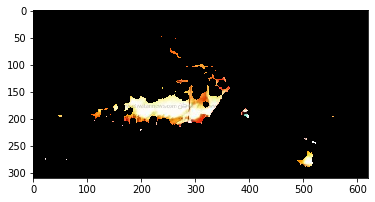

In [9]:
#Image segmentation 

def segment_image(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask) #adding the mask 
    return output/255

segmented_img = segment_image(RGB_eg)
plt.imshow(segmented_img)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


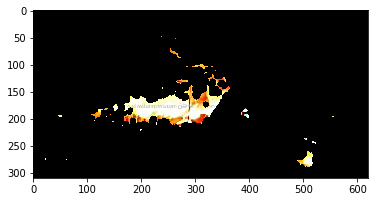

In [10]:
#Image sharpening 

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

sharpened_img = sharpen_image(segmented_img)
plt.imshow(sharpened_img)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


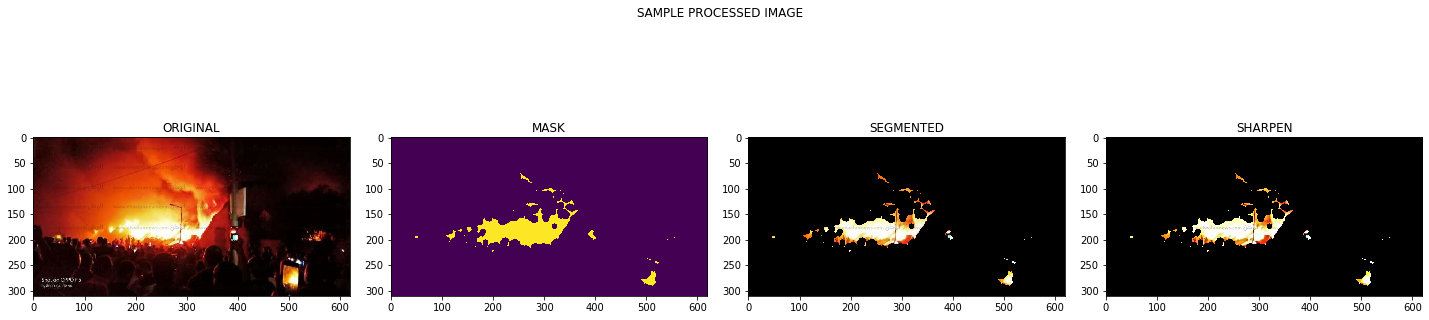

In [11]:
#Displaying effects of preprocessing in a single cell for clarity

fig, ax = plt.subplots(1, 4, figsize=(20, 10));
plt.suptitle('SAMPLE PROCESSED IMAGE', x=0.5, y=0.8)
plt.tight_layout(1)

ax[0].set_title('ORIGINAL', fontsize=12)
ax[1].set_title('MASK', fontsize=12)
ax[2].set_title('SEGMENTED', fontsize=12)
ax[3].set_title('SHARPEN', fontsize=12)

ax[0].imshow(RGB_eg/255);
ax[1].imshow(masked_img);
ax[2].imshow(segmented_img);
ax[3].imshow(sharpened_img);

In [12]:
#Creating a dataframe

df = pd.DataFrame(training_data, columns=['file', 'label'])
df.shape
df.head()

,file,label
0,"[[[24, 8, 8], [24, 8, 8], [26, 8, 8], [26, 7, ...",0
1,"[[[194, 117, 3], [207, 144, 3], [215, 161, 3],...",1
2,"[[[5, 1, 0], [2, 1, 0], [0, 0, 0], [0, 0, 0], ...",0
3,"[[[65, 43, 2], [64, 42, 1], [63, 41, 0], [62, ...",0
4,"[[[149, 118, 135], [128, 115, 132], [125, 117,...",0


APPLYING FEATURE EXTRACTION TO OUR DATAFRAME

In [13]:
#First step: Segmentation function which contains the masking procedure within already - applied to whole data set

df["file"] = df["file"].apply(segment_image) 

In [14]:
#Second step: Sharpening function applied to whole data set

df["file"] = df["file"].apply(sharpen_image)

In [26]:
#Our dataframe reflects the changes as well

df.shape
df.head()

,file,label
0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",0
1,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",1
2,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",0
3,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",0
4,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


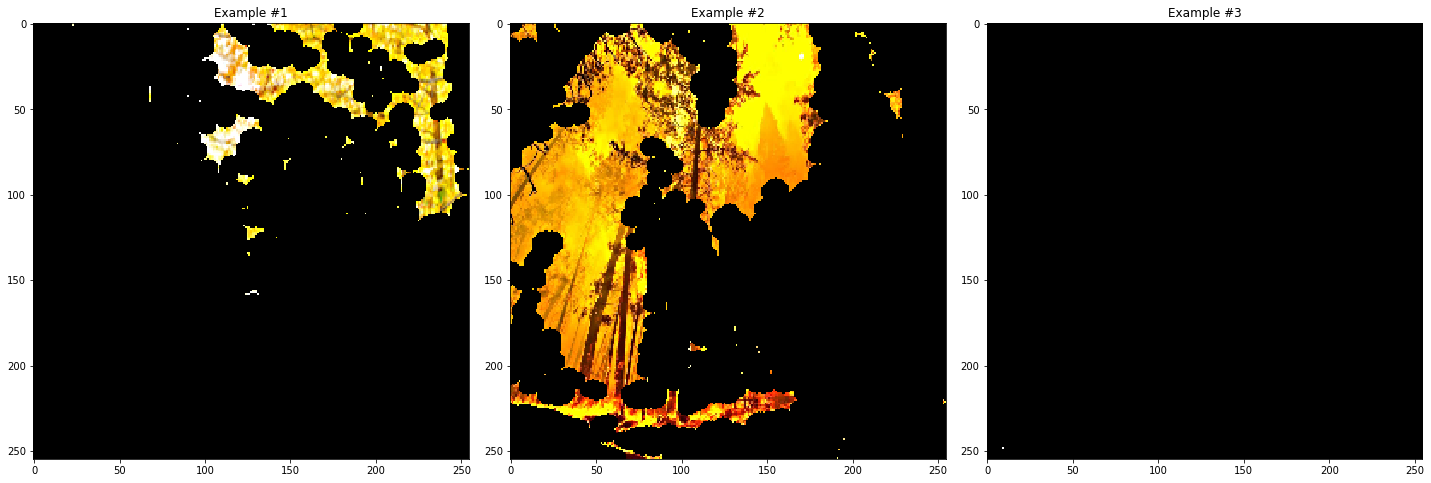

In [165]:
#Checking a couple of examples from our data set after feature extraction

fig, ax = plt.subplots(1, 3, figsize=(20, 10));
plt.tight_layout(1)

ax[0].set_title('Example #1', fontsize=12)
ax[1].set_title('Example #2', fontsize=12)
ax[2].set_title('Example #3', fontsize=12)


ax[0].imshow(df["file"][1]);
ax[1].imshow(df["file"][10]);
ax[2].imshow(df["file"][30]);

plt.show()

In [67]:
#Initiating an empty list for features and labels

X = []
y = []

In [68]:
#Looping through the data and populating the lists accordingly

for file, label in df.itertuples(index=False):
    X.append(file)
    y.append(label)
    
#Reshaping data in a form that's suitable for feeding it into the neural network

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

In [93]:
y=np.array(y)

In [77]:
X.shape

(998, 255, 255, 3)

BUILDING A DEEP LEARNING MODEL

In [115]:
#Building and training the neural network

model = Sequential()
class_weights = compute_class_weight('balanced', np.unique(y), y) #Adding class weights to offset the imbalance in data

model.add(Conv2D(64, (3, 3), input_shape = X.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))

model.add(Dense(1))
model.add(Activation("sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X, y, batch_size=32, validation_split=0.2, epochs=8, class_weight=class_weights)

Train on 798 samples, validate on 200 samples
Epoch 1/8
798/798 [==============================] - 98s 123ms/sample - loss: 0.6615 - accuracy: 0.8033 - val_loss: 0.3698 - val_accuracy: 0.8400
Epoch 2/8
798/798 [==============================] - 96s 120ms/sample - loss: 0.2491 - accuracy: 0.8885 - val_loss: 0.3289 - val_accuracy: 0.8650
Epoch 3/8
798/798 [==============================] - 92s 115ms/sample - loss: 0.1563 - accuracy: 0.9286 - val_loss: 0.3474 - val_accuracy: 0.8650
Epoch 4/8
798/798 [==============================] - 91s 114ms/sample - loss: 0.0716 - accuracy: 0.9536 - val_loss: 0.4407 - val_accuracy: 0.8850
Epoch 5/8
798/798 [==============================] - 89s 112ms/sample - loss: 0.0452 - accuracy: 0.9900 - val_loss: 0.6313 - val_accuracy: 0.8800
Epoch 6/8
798/798 [==============================] - 90s 113ms/sample - loss: 0.0327 - accuracy: 0.9925 - val_loss: 0.7169 - val_accuracy: 0.8750
Epoch 7/8
798/798 [==============================] - 90s 113ms/sample - loss: 

In [116]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Visualizing the performance of the model shows it's behaving as expected - Accuracy is increasing, while Loss is decreasing.

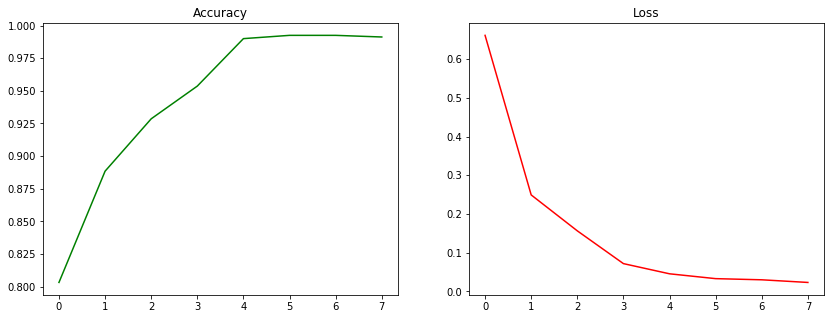

In [150]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].set_title('Accuracy');
ax[1].set_title('Loss');

ax[0].plot(history.history['accuracy'], color="green")
ax[1].plot(history.history['loss'], color="red")

plt.show()

In [133]:
#Extracting the test set

test_split_ratio = 0.2
test_x = X[-math.ceil(len(X)*test_split_ratio):]
test_y = y[-math.ceil(len(X)*test_split_ratio):]

In [135]:
#Making a prediction on the test set

predictions = model.predict_classes(test_x)

In [148]:
#Evaluating model performance based on our prediction

metrics = classification_report(test_y, predictions, output_dict=True)
metrics_table = pd.DataFrame(metrics).transpose()
metrics_table

,f1-score,precision,recall,support
0,0.911565,0.911565,0.911565,147.00
1,0.754717,0.754717,0.754717,53.00
accuracy,0.870000,0.870000,0.870000,0.87
macro avg,0.833141,0.833141,0.833141,200.00
weighted avg,0.870000,0.870000,0.870000,200.00


Recall calculates how many of the Actual Positives our model captures through labeling it as Positive (True Positive). Recall is the best metric to use when there is a high cost associated with False Negatives - which is true in our case, since the worst case scenario is failing to catch a fire that's occured. Our recall is pretty decent in case of positive examples (fire images) - 0.91, which means our model correctly classifies presence of fire on images in 91% of cases.

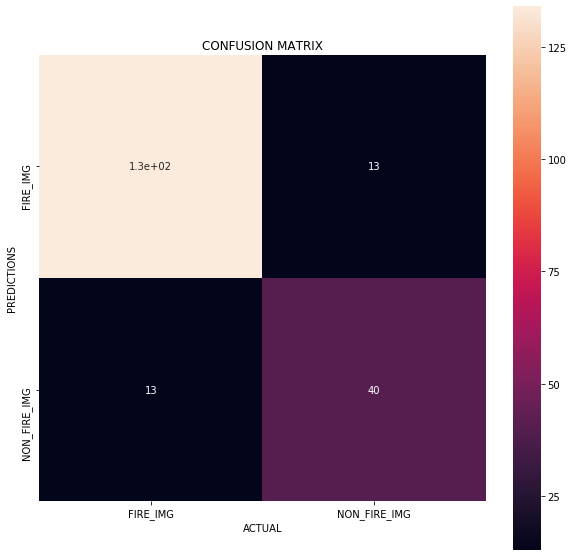

In [164]:
#Visualizing model performance through confusion matrix - ratio of predicted versus actual classes

confusion_mat = confusion_matrix(test_y, predictions)

plt.figure(figsize=(10,10))
sns.heatmap(confusion_mat, square=True, annot=True,
            yticklabels=['FIRE_IMG', 'NON_FIRE_IMG'],
            xticklabels=['FIRE_IMG', 'NON_FIRE_IMG']);
plt.title('CONFUSION MATRIX');
plt.xlabel('ACTUAL');
plt.ylabel('PREDICTIONS');